In [25]:
import random
import math
import numpy as np

import pytorch_lightning as pl
import torch
import torch.nn as nn 
import torch.nn.functional as F
from pytorch_lightning.loggers.wandb import WandbLogger

from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST
import torchvision

from sentence_transformers import SentenceTransformer

import PIL
import os

## Utils

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
digit_task_dictionary = {
    0: [
        "Draw the digit zero",
        "Sketch the number 0",
        "Inscribe the numeral zero",
        "Draft the digit 0",
        "Illustrate the number zero"
    ],
    1: [
        "Draw the digit one",
        "Sketch the number 1",
        "Inscribe the numeral one",
        "Draft the digit 1",
        "Illustrate the number one"
    ],
    2: [
        "Draw the digit two",
        "Sketch the number 2",
        "Inscribe the numeral two",
        "Draft the digit 2",
        "Illustrate the number two"
    ],
    3: [
        "Draw the digit three",
        "Sketch the number 3",
        "Inscribe the numeral three",
        "Draft the digit 3",
        "Illustrate the number three"
    ],
    4: [
        "Draw the digit four",
        "Sketch the number 4",
        "Inscribe the numeral four",
        "Draft the digit 4",
        "Illustrate the number four"
    ],
    5: [
        "Draw the digit five",
        "Sketch the number 5",
        "Inscribe the numeral five",
        "Draft the digit 5",
        "Illustrate the number five"
    ],
    6: [
        "Draw the digit six",
        "Sketch the number 6",
        "Inscribe the numeral six",
        "Draft the digit 6",
        "Illustrate the number six"
    ],
    7: [
        "Draw the digit seven",
        "Sketch the number 7",
        "Inscribe the numeral seven",
        "Draft the digit 7",
        "Illustrate the number seven"
    ],
    8: [
        "Draw the digit eight",
        "Sketch the number 8",
        "Inscribe the numeral eight",
        "Draft the digit 8",
        "Illustrate the number eight"
    ],
    9: [
        "Draw the digit nine",
        "Sketch the number 9",
        "Inscribe the numeral nine",
        "Draft the digit 9",
        "Illustrate the number nine"
    ]
}

In [5]:
text_encoder =  SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

task_text_embeddings = {}
for class_label, formulations in digit_task_dictionary.items():
    # Convert the formulations into embeddings
    task_text_embeddings[class_label] = text_encoder.encode(formulations)

# Convert to tensor of shape (10, 5, 384)
task_text_embeddings = torch.tensor([task_text_embeddings[i] for i in range(10)])

/tmp/ipykernel_1681409/4156803524.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  task_text_embeddings = torch.tensor([task_text_embeddings[i] for i in range(10)])


## DDPM model

In [107]:
class CondDDPM(pl.LightningModule):
    """
    Predicts the noise level for a batch of images.

    Args:
        input (torch.Tensor): A tensor representing a batch of noisy images.
        (batch_size, num_channels, height, width)

    Returns:
        torch.Tensor: A tensor representing the predicted noise level for each image 
            in the batch.(batch_size, num_channels, height, width)
    """
    def __init__(
            self, noise_predictor,
            mask_probability=0.5, 
            num_diff_steps=1000,
            beta_min = 1e-4,
            beta_max = 1e-2,
            w = 0.3, 
            task_text_embeddings = task_text_embeddings
    ) -> None: 
        super().__init__()
        self.noise_predictor = noise_predictor
        self.criterion = torch.nn.MSELoss()
        self.mask_probability = mask_probability
        self.num_diff_steps = num_diff_steps
        self.beta_min = beta_min
        self.beta_max = beta_max
        betas, alphas, alpha_bars = self.get_alpha_bars()
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alpha_bars", alpha_bars)
        self.w = 0.3
        self.register_buffer("task_text_embeddings", task_text_embeddings)

    def get_alpha_bars(self):
        betas = torch.linspace(self.beta_min, self.beta_max, self.num_diff_steps)
        alphas = 1 - betas
        alpha_bars = torch.cumprod(alphas, dim = 0)
        return betas, alphas, alpha_bars
    

    def prepare_texts(self, y):
        """Takes in (batch_size, 1), converts to randomly sampled texts,
        mask out with self.mask_probability. Outputs (batch_size, num_text_tokens, text_embedding_size)
        WIP, naive copilot implementation
        """

        # Choose random task formulation embedding for each sample
        y = y.view(-1)
        batch_size = y.shape[0]
        num_examples = self.task_text_embeddings.shape[1]
        random_indices = torch.randint(num_examples, size=(batch_size,))
        chosen_embeddings = self.task_text_embeddings[y, random_indices]
        
        # Mask out the whole embedding (row) with probability self.mask_probability
        mask = torch.bernoulli(torch.ones(batch_size) - self.mask_probability).to(chosen_embeddings.device)
        mask = mask.view(-1, 1).expand_as(chosen_embeddings)
        #print("---- devices in prepare_texts ----")
        #print(f"chosen_embeddings: {chosen_embeddings.device}")
        #print(f"mask: {mask.device}")
        
        chosen_embeddings = chosen_embeddings * mask

        return chosen_embeddings
    
    def forward_diffusion(self, x_0, alpha_bars, noise):
        assert x_0.shape[0] == alpha_bars.shape[0], f"Shape of x_0: {x_0.shape}, shape of alpha_bars: {alpha_bars.shape}"
        alpha_bars = alpha_bars.view(-1, 1, 1, 1)
        #print("---- devices ----")
        #print(f"x_0: {x_0.device}")
        #print(f"alpha_bars: {alpha_bars.device}")
        #print(f"noise: {noise.device}")
        
        x_t = torch.sqrt(alpha_bars) * x_0 + torch.sqrt(1 - alpha_bars) * noise
        return x_t

    def generate_images(self, task_embedding):
        """
        Args:
            task_embedding (354,)
        Output:
            generated_image (1, 1, 28, 28)
        """
        x = torch.randn(1, 1, 28, 28).to(self.device)
        if torch.cuda.is_available():
            torch.backends.cudnn.enabled = True
            print("cudnn is available")
        else:
            print("cudnn is not available")
        uncond_embedding = torch.zeros_like(task_embedding)
        embedding_concat = torch.cat([uncond_embedding, task_embedding], dim=0)

        # Pre-allocation
        z = torch.zeros(1, 1, 28, 28).to(self.device)
        with torch.no_grad():
            for t in tqdm(torch.range(self.num_diff_steps-1, 0, -1, dtype=torch.long, device=self.device)):
                if t > 0:
                    z.normal_()
                else:
                    z.zero_()

                alpha_t = self.alphas[t]
                alpha_bar_t = self.alpha_bars[t]
                beta_t = self.betas[t]
                t = t.float()

                x_concat = x.repeat(2, 1, 1, 1)
                t_concat = t.repeat(2)

                output = self.noise_predictor(x_concat, embedding_concat, t_concat)
                noise_pred_uncond = output[0]
                noise_pred = output[1]
                noise_pred_weighted = (1+self.w)*noise_pred - self.w*noise_pred_uncond

                x.sub_(((1-alpha_t)/torch.sqrt(1 - alpha_bar_t)) * noise_pred_weighted)
                x.div_(torch.sqrt(alpha_t))
                x.add_(torch.sqrt(beta_t) * z)
        return x

    def forward(self, x, c, t):
        return self.noise_predictor(x, c, t)
    
    def training_step(self, batch):
        x, y = batch
        masked_y = self.prepare_texts(y)
        eps = torch.randn_like(x)
        n = len(x)
        # sample ts as torch.long from a uniform distribution
        ts = torch.randint(0, self.num_diff_steps, (n,), dtype=torch.long, device=self.device)
        alpha_bars_ts = self.alpha_bars[ts]
        ts = ts.float()
        
        preds = self.noise_predictor(self.forward_diffusion(x, alpha_bars_ts, eps), masked_y, ts)
        loss = self.criterion(preds, eps)
        
        # log the loss
        self.log("train_loss", loss)
        
        return loss
        
    def configure_optimizers(self, lr=1e-3):
        return torch.optim.Adam(self.parameters(), lr=lr)
    
    def on_train_epoch_end(self):
        query = "Draw the digit zero"
        query_embedding = torch.tensor(text_encoder.encode(query)).to(self.device)
        x = self.generate_images(query_embedding)
        #x = torch.randn(1, 1, 28, 28).to(self.device)
        x = x.view(-1, 28, 28)
        #grid = torchvision.utils.make_grid(x)
        images = [image for image in x]
        self.logger.log_image("samples", images, self.current_epoch)


### Noise predictor model

In [108]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    """Used for embedding context and diffusion time step"""
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """ print("--- devices in EmbedFC ---")
        print(f"x: {x.device} \n")
        print(f"self.model: {self.model[0].weight.device} \n") """

        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    """ Based on this architecture: https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py"""
    def __init__(self, in_channels = 1, n_feat = 256, context_dim=384):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = context_dim

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(self.n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(self.n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        #print("shape of cemb1", cemb1.shape)
        #print("shape of up1", up1.shape)
        #print("shape of temb1", temb1.shape)
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


ddpm = CondDDPM(ContextUnet())

## Load the data

In [8]:
def show_images(images, title=""):
    images = images.detach()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

In [9]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)

## Fit the model

In [105]:
# hyperparameters
batch_size = 64
num_epochs = 10

In [11]:
loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=64)

In [106]:
wandb_logger = WandbLogger(project="language-cond-ddpm-lightning")
trainer = pl.Trainer(max_epochs=num_epochs, 
                     logger=wandb_logger, devices=1, 
                     accelerator='gpu',
                     profiler="simple")
trainer.fit(ddpm, loader)   

TypeError: __init__() got an unexpected keyword argument 'learning_rate'

In [40]:
# save the model
torch.save(ddpm.state_dict(), "checkpoints/lang_cond_ddpm_neew.ckpt")

## Interactive sampling

/tmp/ipykernel_1681409/4275961133.py:98: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for t in tqdm(torch.range(self.num_diff_steps-1, 0, -1, dtype=torch.long, device=self.device)):


cudnn is available


100%|██████████| 1000/1000 [00:40<00:00, 24.42it/s]


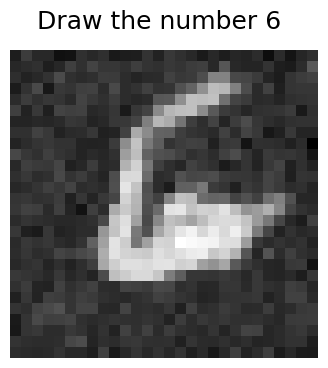

In [109]:
#load the model
ddpm.load_state_dict(torch.load("checkpoints/lang_cond_ddpm_new.ckpt"))

query = "Draw the number 6"
query_embedding = torch.tensor(text_encoder.encode(query))

show_images(ddpm.generate_images(query_embedding), title=query)
    